# Генерация изображений рабочих с наличием/отсутствием касок на голове
## 1. **Загрузка датасета:**

In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
file_id = '1kimcOWXBP-ILJZmcoVqrRO_QW4ckM0PO'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('/content/HelmetProtection.zip') # Загрузка архива с Google-диска

In [ ]:
# Распаковка архива
!unzip -q /content/HelmetProtection.zip -d /content/
!rm /content/HelmetProtection.zip

# Сохранение всех изображений в одну папку all_images
!mkdir /content/HelmetProtection/all_images
!cp -r /content/HelmetProtection/part1/. /content/HelmetProtection/all_images
!cp -r /content/HelmetProtection/part2/. /content/HelmetProtection/all_images
!cp -r /content/HelmetProtection/part3/. /content/HelmetProtection/all_images

!rm -R /content/HelmetProtection/part1/
!rm -R /content/HelmetProtection/part2/
!rm -R /content/HelmetProtection/part3/

In [4]:
import os
import json
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageSequence
from tqdm import tqdm

In [5]:
def get_im_js(path): # получение названий файлов для формирования датасетов
  file_list = os.listdir(path)
  js_files_names = [x[:-5] for x in file_list if x[-5:] == '.json'] # получаем названия json-файлов

  im_files = [x for x in file_list if (x[-5:] != '.json') and (''.join(x.split('.')[:-1]) in js_files_names)] # получаем названия изображений, для которых есть json-файлы, указанные в списке js_files_names
  js_files = [''.join(x.split('.')[:-1]) + '.json' for x in im_files] # получаем названия json-файлов, отсеивая те, для которых нет соответствующих им изображений

  return (im_files, js_files)

def split_and_save(from_path, to_path): # сохраняет обрезанные изображения и возвращает 2 списка их имён (в касках и без)
  im_files, js_files = get_im_js(from_path)
  crop_imgs_k = []
  crop_imgs_nk = []
  for im_name, js_name in tqdm(zip(im_files, js_files)):
    if (im_name[-4:] != '.gif'):
      img = cv2.imread(os.path.join(from_path,im_name))
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
      image = Image.open(os.path.join(from_path,im_name))
      frames = ImageSequence.Iterator(image)
      image = frames[0].copy()
      img = np.array(image.convert('RGB'))
    with open(from_path + js_name, "r") as read_file:
      try:
        data = json.load(read_file)
      except:
        continue
    
    k = 0
    for shape in data['shapes']:
      i1, j1 = np.int32(shape['points'][0][0]), np.int32(shape['points'][0][1])
      i2, j2 = np.int32(shape['points'][1][0]), np.int32(shape['points'][1][1])

      i1, i2 = min(i1,i2), max(i1,i2)
      j1, j2 = min(j1,j2), max(j1,j2)

      file_name = str(k) + ''.join(im_name.split('.')[:-1]) + '.jpg'
      if shape['label'] == 'kaska_on':
        crop_imgs_k.append(file_name)
      else:
        crop_imgs_nk.append(file_name)

      cropped_img = cv2.cvtColor(img[j1:j2,i1:i2,:], cv2.COLOR_RGB2BGR)
      cv2.imwrite(to_path + file_name, cropped_img)
      k += 1

  return (crop_imgs_k, crop_imgs_nk)

In [6]:
# Сохраняем изображения голов в папку all_cropped_images

!rm -R /content/HelmetProtection/all_cropped_images
!mkdir /content/HelmetProtection/all_cropped_images
crop_imgs_k, crop_imgs_nk = split_and_save('/content/HelmetProtection/all_images/', '/content/HelmetProtection/all_cropped_images/')

rm: cannot remove '/content/HelmetProtection/all_cropped_images': No such file or directory


2107it [01:22, 25.65it/s]


## 3. **Обучение модели:**

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import time

In [8]:
GENERATE_RES = 2 # Generation resolution factor 
# (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES # rows/cols (should be square)
IMAGE_CHANNELS = 3

PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

SEED_SIZE = 100

DATA_PATH = '/content/HelmetProtection/all_cropped_images/'
EPOCHS = 100
BATCH_SIZE = 32
BUFFER_SIZE = 60000

print(f"Will generate {GENERATE_SQUARE}px square images.")

Will generate 64px square images.


In [9]:
# Форматирование вывода времени
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

Перед обучением приведём все изображения в датасете к размеру `GENERATE_SQUARE x GENERATE_SQUARE`, выполним нормализацию данных и сохраним их .npy файл

In [10]:
training_binary_path = f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy'

print(f"Looking for file: {training_binary_path}")

if not os.path.isfile(training_binary_path):
  start = time.time()
  print("Loading training images...")

  training_data = []
  faces_path = DATA_PATH
  for filename in tqdm(os.listdir(faces_path)):
      path = os.path.join(faces_path,filename)
      image = Image.open(path).resize((GENERATE_SQUARE,
            GENERATE_SQUARE),Image.ANTIALIAS)
      training_data.append(np.asarray(image))
  training_data = np.reshape(training_data,(-1,GENERATE_SQUARE, GENERATE_SQUARE,IMAGE_CHANNELS))
  training_data = training_data.astype(np.float32)
  training_data = training_data / 127.5 - 1.


  print("Saving training image binary...")
  np.save(training_binary_path,training_data)
  elapsed = time.time()-start
  print (f'Image preprocess time: {hms_string(elapsed)}')
else:
  print("Loading previous training pickle...")
  training_data = np.load(training_binary_path)

Looking for file: training_data_64_64.npy
Loading training images...


100%|██████████| 4423/4423 [00:09<00:00, 458.60it/s]


Saving training image binary...
Image preprocess time: 0:00:10.22


Считываем датасет из .npy файла:

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices(training_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Для генератора и дискриминатора будем использовать следующие архитектуры:

In [12]:
def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
   
    # Output resolution, additional upsampling
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    if GENERATE_RES>1:
      model.add(UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
      model.add(Conv2D(128,kernel_size=3,padding="same"))
      model.add(BatchNormalization(momentum=0.8))
      model.add(Activation("relu"))

    # Final CNN layer
    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model


def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

Для того, чтобы можно было отследить прогресс обучения напишем функцию, с помощью которой будем сохранять неколько примеров изображений сгенерированных генератором после каждой эпохи:

In [13]:
def save_images(cnt,noise):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), IMAGE_CHANNELS), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
            = generated_images[image_count] * 255
        image_count += 1

          
  output_path = '/content/HelmetProtection/output/'
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

Можно видеть, что необученный генератор выдаёт шум:

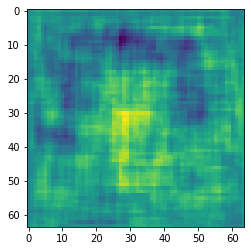

In [14]:
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS) # инициализация генератора
noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [15]:
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape) # инициализация дискриминатора
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.50059056]], shape=(1, 1), dtype=float32)


Функции потерь для генератора и дискриминатора:

In [16]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [17]:
# В качестве метода оптимизации будем использовать Adam

generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

Функции для обучения GAN-модели:

In [18]:
@tf.function
def train_step(images): # Шаг градиентного спуска
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  return gen_loss,disc_loss


def train(dataset, epochs): # Обучение с выбранным датасетом и заданным количеством эпох
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, 
                                       SEED_SIZE))
  start = time.time()

  min_loss = 1000
  g_loss = []
  d_loss = []
  for epoch in range(epochs):
    epoch_start = time.time()
  

    gen_loss_list = []
    disc_loss_list = []


    for image_batch in dataset:
      #print(image_batch.shape)
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss.append(sum(gen_loss_list) / len(gen_loss_list))
    d_loss.append(sum(disc_loss_list) / len(disc_loss_list))
    generator.save('/content/last_generator.h5')

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss[-1]},disc loss={d_loss[-1]},'\
           f' {hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed)

  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')
  return g_loss, d_loss

Компиляция модели и запуск обучения:

***Чтобы не обучать сеть при повторном запуске, в блоке кода после примеров сгенерированных изображений (ниже) можно загрузить обученные веса с Github!***

In [24]:
gen_loss_list, disc_loss_list = train(train_dataset, EPOCHS)

Epoch 1, gen loss=2.230729818344116,disc loss=0.9589434266090393, 0:00:41.41
Epoch 2, gen loss=2.6587865352630615,disc loss=1.1076042652130127, 0:00:19.95
Epoch 3, gen loss=1.993085503578186,disc loss=1.3027105331420898, 0:00:20.01
Epoch 4, gen loss=1.5990115404129028,disc loss=1.4239200353622437, 0:00:20.01
Epoch 5, gen loss=1.7404406070709229,disc loss=1.223833680152893, 0:00:20.01
Epoch 6, gen loss=1.7255386114120483,disc loss=1.241542100906372, 0:00:20.00
Epoch 7, gen loss=1.5924044847488403,disc loss=1.1579270362854004, 0:00:19.99
Epoch 8, gen loss=1.642572283744812,disc loss=1.0942916870117188, 0:00:19.98
Epoch 9, gen loss=1.6284458637237549,disc loss=1.1511592864990234, 0:00:19.99
Epoch 10, gen loss=1.4510520696640015,disc loss=1.2316255569458008, 0:00:19.94
Epoch 11, gen loss=1.2547688484191895,disc loss=1.3058772087097168, 0:00:19.94
Epoch 12, gen loss=1.206489086151123,disc loss=1.2858309745788574, 0:00:19.92
Epoch 13, gen loss=1.2200253009796143,disc loss=1.2933322191238403,

Графики функций потерь для генератора и дискриминатора:

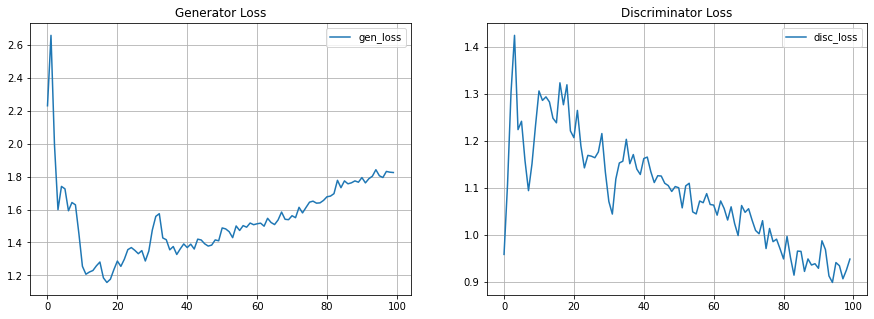

In [25]:
fig, ax = plt.subplots(1,2)
fig.set_figwidth(15)
fig.set_figheight(5)
ax[0].plot(gen_loss_list, label='gen_loss')
ax[0].grid()
ax[0].set(title='Generator Loss')
ax[0].legend()

ax[1].plot(disc_loss_list, label='disc_loss')
ax[1].grid()
ax[1].set(title='Discriminator Loss')
ax[1].legend()

Пример изображений сгенерированных сетью с весами после k эпох обучения:

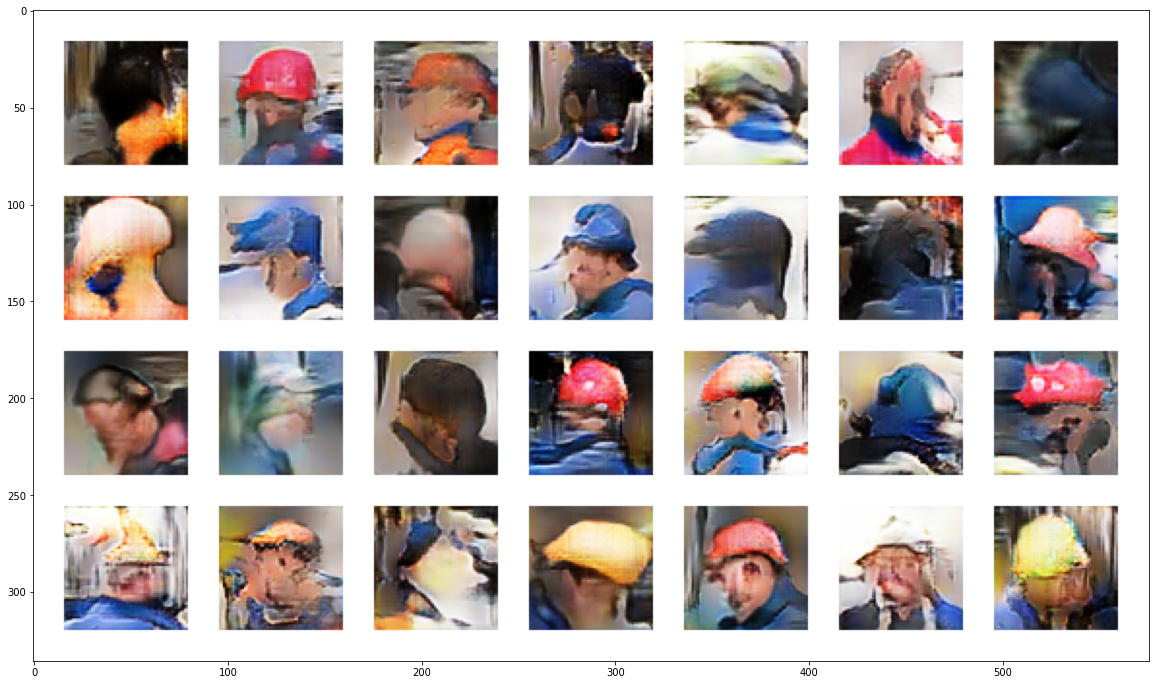

In [28]:
k = EPOCHS - 1

img = cv2.imread('/content/HelmetProtection/output/train-' + str(k) + '.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(20)

plt.imshow(img, vmin = 0, vmax = 255)


In [21]:
# Загрузка обученных весов с Github
git_repo_url = 'https://github.com/alimagadovk/MIET.AI.Course'
project_name = git_repo_url.split('/')[0]
if not os.path.exists(project_name):
  !git clone -q $git_repo_url
  !cp '/content/MIET.AI.Course/Лекция 5/Homework/last_generator.h5' '/content/'
  !rm -R /content/MIET.AI.Course

generator.load_weights('last_generator.h5') # загрузка обученных весов

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


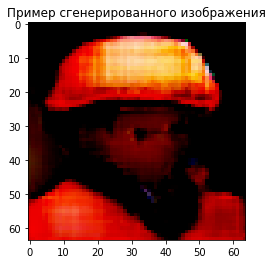

In [83]:
noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, :], vmin = 0, vmax = 255)
plt.title("Пример сгенерированного изображения");